
Quick Looks at the Data
==========================
These are quick ways you can have a look at the data you have. These give you some insight, but they are not statistically rigorous (rigor needs the Likelihood method).  The data you are about to see have not been corrected for things like livetime, exposure, background, random acts of statistics etc.  but go for it…

**Goal:**  *Make simple views of the data, establish individual projects*

In [1]:
from IPython.display import Image,HTML

In [2]:
from astropy.io import fits as pyfits

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import gt_apps


### Using gtbin to make a counts map

*[gtbin](http://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/help/gtbin.txt)* is a pretty versitle tool: It can make:
* counts maps (counts_map + CMAP)
* healpix maps (counts_map + HEALPIX)
* counts cubes (counts_map + CCUBE)
* simple light curves (evtbin + LC)
* simple spectra (evtbin + PHA1/PHA2)

We're going to make a counts map and plot it with python.  You can also use [ds9](http://hea-www.harvard.edu/RD/ds9/site/Home.html) or fv to plot this.

In [5]:
from gt_apps import counts_map
counts_map['evfile'] = '../data/3C279_mktime.fits'
counts_map['scfile'] = 'NONE'
counts_map['outfile'] = '../data/3C279_cmap.fits'
counts_map['algorithm'] = 'CMAP'
counts_map['xref'] = 194.0
counts_map['yref'] = -5.8
counts_map['coordsys'] = 'CEL'
counts_map['nxpix'] = 400
counts_map['nypix'] = 400
counts_map['binsz'] = 0.1
counts_map['axisrot'] = 0.0
counts_map['proj'] = 'AIT'
counts_map.run()

time -p gtbin evfile=../data/3C279_mktime.fits scfile=NONE outfile=../data/3C279_cmap.fits algorithm="CMAP" ebinalg="LOG" emin=100.0 emax=100000.0 enumbins=20 denergy=0.0 ebinfile=NONE tbinalg="LIN" tstart=0.0 tstop=0.0 dtime=0.0 tbinfile=NONE snratio=0.0 lcemin=0.0 lcemax=0.0 nxpix=400 nypix=400 binsz=0.1 coordsys="CEL" xref=194.0 yref=-5.8 axisrot=0.0 rafield="RA" decfield="DEC" proj="AIT" hpx_ordering_scheme="RING" hpx_order=3 hpx_ebin=yes hpx_region="" evtable="EVENTS" sctable="SC_DATA" efield="ENERGY" tfield="TIME" chatter=2 clobber=yes debug=no gui=no mode="ql"


This is gtbin version HEAD
gtbin: WARNING: No spacecraft file: EXPOSURE keyword will be set equal to ontime.
real 0.70
user 0.26
sys 0.33


In [6]:
cmap = pyfits.open('../data/3C279_cmap.fits')

In [7]:
cmap.info()

Filename: ../data/3C279_cmap.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     129   (400, 400)   int32   
  1  GTI           1 BinTableHDU     48   2791R x 2C   [D, D]   


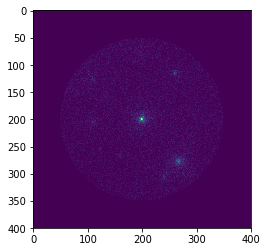

In [8]:
imshow(cmap[0].data)

Note that I'm not using any packages to figure out the World Coordinate System (WCS) of this image so the X and Y are just pixel coordinates.  I could use ds9, fv or aplpy to get proper RA/DEC on this.  But you can immediately see the ROI cut we made, 3C 279 at the center and the other two to five background sources in the field of view.  It'll take a likelihood analysis to wrangle out all of the relevant details about these sources…that's for tomorrow.

## Using gtselect to make a light curve.

We can use gtselect to make a really tight selection around 3C 279. And since it's so bright we can assume that what we're looking at is almost entirely due to the photons from the AGN.  

In [9]:
from gt_apps import filter

In [10]:
filter['infile'] = '../data/3C279_mktime.fits'
filter['outfile'] = '../data/3C279_1deg.fits'
filter['ra'] = 194.047
filter['dec'] = -5.78931
filter['rad'] = 1.0
filter['tmin'] = 'INDEF'
filter['tmax'] = 'INDEF'
filter['emin'] = 100
filter['emax'] = 300000
filter['zmax'] = 90
filter['evclass'] = 128
filter['evtype'] = 3

In [11]:
filter.command()

'time -p gtselect infile=../data/3C279_mktime.fits outfile=../data/3C279_1deg.fits ra=194.047 dec=-5.78931 rad=1.0 tmin="INDEF" tmax="INDEF" emin=100.0 emax=300000.0 zmin=0.0 zmax=90.0 evclass=128 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"'

In [12]:
filter.run()

time -p gtselect infile=../data/3C279_mktime.fits outfile=../data/3C279_1deg.fits ra=194.047 dec=-5.78931 rad=1.0 tmin="INDEF" tmax="INDEF" emin=100.0 emax=300000.0 zmin=0.0 zmax=90.0 evclass=128 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"


Done.
real 0.78
user 0.54
sys 0.18


In [13]:
lc_gtselect = pyfits.open('../data/3C279_1deg.fits')

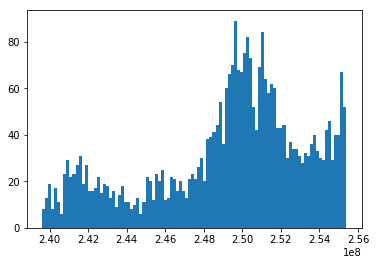

In [14]:
n, bins, patches = hist(lc_gtselect[1].data.field('TIME'), bins=100)

### Using gtbin to make a light curve

It looks a bit weird using a histogram to make a light curve.  We can use *gtbin* to make a more 'sciency' light curve with errors and everything.  We should probably first run gtmktime to update the GTIs of the file we just made.

In [15]:
from gt_apps import maketime, evtbin

In [16]:
maketime['scfile'] = '../data/SC00.fits'
maketime['filter'] = "(DATA_QUAL==1)&&(LAT_CONFIG==1)"
maketime['roicut'] = 'yes'
maketime['evfile'] = '../data/3C279_1deg.fits'
maketime['outfile'] = '../data/3C279_1deg_gti.fits'

In [17]:
maketime.run()

time -p gtmktime scfile=../data/SC00.fits sctable="SC_DATA" filter="(DATA_QUAL==1)&&(LAT_CONFIG==1)" roicut=yes evfile=../data/3C279_1deg.fits evtable="EVENTS" outfile="../data/3C279_1deg_gti.fits" apply_filter=yes overwrite=no header_obstimes=yes tstart=0.0 tstop=0.0 gtifile="default" chatter=2 clobber=yes debug=no gui=no mode="ql"


real 1.89
user 1.38
sys 0.25


In [18]:
print evtbin.pars()

 evfile=../data/3C279_mktime.fits scfile=NONE outfile=../data/3C279_ccube.fits algorithm="CCUBE" ebinalg="LOG" emin=100.0 emax=100000.0 enumbins=20 denergy=0.0 ebinfile=NONE tbinalg="LIN" tstart=0.0 tstop=0.0 dtime=0.0 tbinfile=NONE snratio=0.0 lcemin=0.0 lcemax=0.0 nxpix=100 nypix=100 binsz=0.2 coordsys="CEL" xref=194.047 yref=-5.78931 axisrot=0.0 rafield="RA" decfield="DEC" proj="CAR" hpx_ordering_scheme="RING" hpx_order=3 hpx_ebin=yes hpx_region="" evtable="EVENTS" sctable="SC_DATA" efield="ENERGY" tfield="TIME" chatter=2 clobber=yes debug=no gui=no mode="ql"


In [19]:
evtbin['algorithm'] = 'LC'
evtbin['outfile'] = '../data/3C279_1deg_lc.fits'
evtbin['evfile'] = '../data/3C279_1deg_gti.fits'
evtbin['scfile'] = '../data/SC00.fits'
evtbin['tbinalg'] = 'LIN'
evtbin['tstart'] = 239557417
evtbin['tstop'] = 255398400
evtbin['dtime'] = 86400

In [20]:
evtbin.run()

time -p gtbin evfile=../data/3C279_1deg_gti.fits scfile=../data/SC00.fits outfile=../data/3C279_1deg_lc.fits algorithm="LC" ebinalg="LOG" emin=100.0 emax=100000.0 enumbins=20 denergy=0.0 ebinfile=NONE tbinalg="LIN" tstart=239557417.0 tstop=255398400.0 dtime=86400.0 tbinfile=NONE snratio=0.0 lcemin=0.0 lcemax=0.0 nxpix=100 nypix=100 binsz=0.2 coordsys="CEL" xref=194.047 yref=-5.78931 axisrot=0.0 rafield="RA" decfield="DEC" proj="CAR" hpx_ordering_scheme="RING" hpx_order=3 hpx_ebin=yes hpx_region="" evtable="EVENTS" sctable="SC_DATA" efield="ENERGY" tfield="TIME" chatter=2 clobber=yes debug=no gui=no mode="ql"


This is gtbin version HEAD
real 1.00
user 0.69
sys 0.20


In [21]:
lc_gtbin = pyfits.open('../data/3C279_1deg_lc.fits')

<Container object of 3 artists>

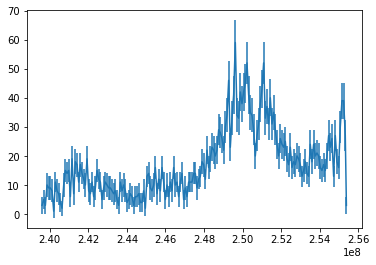

In [22]:
errorbar(lc_gtbin[1].data.field('TIME'),lc_gtbin[1].data.field('Counts'),yerr=lc_gtbin[1].data.field('Error'))

### Other views of the data
Of course, we can't go over all of the ways you can quickly look at the data here are some others (and links to examples):

* [Aperture photometry](http://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/aperture_photometry.html)
    * R. Corbet of the FSSC also generates [Light curves for all of the 3FGL sources](http://fermi.gsfc.nasa.gov/ssc/data/access/lat/4yr_catalog/ap_lcs.php).
* Exposure corrected light curves.
* Looking for clusters of photons.
* And lots more...


Projects!
============


Our goal is to help you complete an analysis on a topic of your choice during the next two weeks. We're happy to work on both simple and complex projects, but we are unlikely to have enough time/computational power to complete the complex ones.

Simple project examples:
* Single source spectral and variability analysis for point sources, extended sources, etc.
* Time-dependent characteristics of gamma-ray binaries
* GRB spectra and light curves
* Temporal and spectral characteristics of stellar novae
* Pulsar spectral analysis, weighting, and pulsation searching (using a known pulsar with current timing information)

Complex project examples:
* Characterization of a large-scale/all-sky signal: anisotropy in the EBL, dark matter signals in the GC, Galactic diffuse emission
* Stacking analyses: searching for AGN halos, dark matter search from dwarf spheroidal galaxies
* Searching for new pulsars in the gamma rays
* Characterizing the positron/electron ratio detected by the LAT

## What would you like to do with Fermi data?